# Plot Data of Environmental Network within ROMY

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

from obspy import UTCDateTime, Stream

In [2]:
# sys.path.append('..')

In [3]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals
from functions.read_sds import __read_sds
from functions.load_furt_stream import __load_furt_stream

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def __find_min_max_stream(_st, _cha):

    from numpy import nanmin, nanmax, nanpercentile

    arr = []
    for tr in _st:
        if tr.stats.channel == _cha:
            arr.append(tr.data)

    return nanpercentile(arr, 0.05), nanpercentile(arr, 99.95)

In [7]:
def __find_min_max(_df, _cha):

    from numpy import nanmin, nanmax, nanpercentile, array, append

    arr = array([])
    for _k in _df.keys():
        arr = append(arr, array(_df[_k][_cha]))

    return nanpercentile(arr, 0.05), nanpercentile(arr, 99.95)

In [8]:
def __read_data(t1, t2, cha, path_to_data):

    from pandas import DataFrame, read_csv, concat
    from numpy import nan
    from obspy import UTCDateTime


    path = f"{path_to_data}{config['tbeg'].year}/BW/WROMY/{cha}.D/"

    if not os.path.isdir(path):
        print(f" -> Path: {path}, does not exists!")
        return

    j1, j2 = UTCDateTime(t1).julday, UTCDateTime(t2).julday
    year = UTCDateTime(t1).year

    df = DataFrame()

    for doy in range(j1, j2+1):

        filename = f'BW.WROMY.{cha}.D.{year}.{doy}'

        print(f'   reading {filename} ...')

        try:
            df0 = read_csv(path+filename)

            # replace error indicating values (-9999, 999.9) with NaN values
            df0.replace(to_replace=-9999, value=nan, inplace=True)
            df0.replace(to_replace=999.9, value=nan, inplace=True)


            if doy == j1:
                df = df0
            else:
                df = concat([df, df0])
        except:
            print(f" -> file: {filename}, does not exists!")

    df.reset_index(inplace=True, drop=True)

    # add columns with total seconds
    if 'Seconds' in df.columns:
        totalSeconds = df.Seconds + (df.Date - df.Date.iloc[0]) * 86400
        df['totalSeconds'] = totalSeconds

    return df

In [9]:
config = {}

# define path to data
config['path_to_sds'] = archive_path+"romy_archive/"

# path to figure output
config['path_to_figs'] = root_path+f"Documents/ROMY/HTML_Monitor/figures/"

# specify length of time interval to show
config['time_interval'] = 3 # days

# define time interval
config['tend'] = UTCDateTime().now()
config['tbeg'] = config['tend'] - config['time_interval'] * 86400

# specify wromy stations to use
config['wromy_stations'] = [1, 4, 5, 6, 7, 8, 9]

# specify promy stations to use
config['promy_stations'] = [1, 4, 5, 7, 9]

# specify colors for stations
config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

### Load Maintenance Log

In [10]:
try:
    # load log file
    lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

    # get intervals of maintenance work as utc times
    lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

except Exception as e:
    print(e)
    print(f" -> failed to load maintenance log")


### Load WROMY data

In [11]:
# ws = Stream()

# for _s in config['wromy_stations']:
#     try:
#         ws += __read_sds(archive_path+"temp_archive/", f"BW.WROMY.0{_s}.L*I", config['tbeg'], config['tend'])
#     except:
#         print(f" -> failed to load WS: {_s}")

# ws = ws.merge();

# ws

In [12]:
ws = {}

for _s in config['wromy_stations']:
    try:
        _ws = __read_data(config['tbeg'], config['tend'], f"WS{_s}", archive_path+"romy_archive/")

        _ws_times_utc = [UTCDateTime(f"{d}T{str(t).rjust(6, '0')}") for d, t in zip(_ws['Date'], _ws['Time (UTC)'])]

        ws[_s] = {"time": np.array(_ws_times_utc),
                  "LKI": np.array(_ws['Temperature (°C)']),
                  "LDI": np.array(_ws['Pressure (hPa)']),
                  "LII": np.array(_ws['rel. Humidity (%)']),
                 }
    except Exception as e:
        print(e)
        print(f" -> failed to load WS: {_s}")


   reading BW.WROMY.WS1.D.2024.176 ...
   reading BW.WROMY.WS1.D.2024.177 ...
   reading BW.WROMY.WS1.D.2024.178 ...
   reading BW.WROMY.WS1.D.2024.179 ...
   reading BW.WROMY.WS4.D.2024.176 ...
   reading BW.WROMY.WS4.D.2024.177 ...
   reading BW.WROMY.WS4.D.2024.178 ...
   reading BW.WROMY.WS4.D.2024.179 ...
   reading BW.WROMY.WS5.D.2024.176 ...
   reading BW.WROMY.WS5.D.2024.177 ...
   reading BW.WROMY.WS5.D.2024.178 ...
   reading BW.WROMY.WS5.D.2024.179 ...
   reading BW.WROMY.WS6.D.2024.176 ...
   reading BW.WROMY.WS6.D.2024.177 ...
   reading BW.WROMY.WS6.D.2024.178 ...
   reading BW.WROMY.WS6.D.2024.179 ...
   reading BW.WROMY.WS7.D.2024.176 ...
   reading BW.WROMY.WS7.D.2024.177 ...
   reading BW.WROMY.WS7.D.2024.178 ...
   reading BW.WROMY.WS7.D.2024.179 ...
   reading BW.WROMY.WS8.D.2024.176 ...
   reading BW.WROMY.WS8.D.2024.177 ...
   reading BW.WROMY.WS8.D.2024.178 ...
   reading BW.WROMY.WS8.D.2024.179 ...
   reading BW.WROMY.WS9.D.2024.176 ...
   reading BW.WROMY.WS9.D

### Load PROMY data

In [13]:
ps = Stream()

for _s in config['promy_stations']:
    try:
        ps += __read_sds(archive_path+"temp_archive/", f"BW.PROMY.0{_s}.L*I", config['tbeg'], config['tend'])
    except Exception as e:
        print(e)
        print(f" -> failed to load PS: {_s}")

ps3 = ps.merge();

ps

10 Trace(s) in Stream:
BW.PROMY.01.LDI | 2024-06-24T15:20:59.000000Z - 2024-06-26T23:59:59.000000Z | 1.0 Hz, 203941 samples
BW.PROMY.01.LKI | 2024-06-24T15:20:59.000000Z - 2024-06-26T23:59:59.000000Z | 1.0 Hz, 203941 samples
BW.PROMY.04.LDI | 2024-06-24T15:20:59.000000Z - 2024-06-26T23:59:59.000000Z | 1.0 Hz, 203941 samples
BW.PROMY.04.LKI | 2024-06-24T15:20:59.000000Z - 2024-06-26T23:59:59.000000Z | 1.0 Hz, 203941 samples
BW.PROMY.05.LDI | 2024-06-24T15:20:59.000000Z - 2024-06-26T23:59:59.000000Z | 1.0 Hz, 203941 samples
BW.PROMY.05.LKI | 2024-06-24T15:20:59.000000Z - 2024-06-26T23:59:59.000000Z | 1.0 Hz, 203941 samples
BW.PROMY.07.LDI | 2024-06-24T15:20:59.000000Z - 2024-06-26T23:59:59.000000Z | 1.0 Hz, 203941 samples
BW.PROMY.07.LKI | 2024-06-24T15:20:59.000000Z - 2024-06-26T23:59:59.000000Z | 1.0 Hz, 203941 samples
BW.PROMY.09.LDI | 2024-06-24T15:20:59.000000Z - 2024-06-26T23:59:59.000000Z | 1.0 Hz, 203941 samples
BW.PROMY.09.LKI | 2024-06-24T15:20:59.000000Z - 2024-06-26T23:59:59.

### Load FURT data

In [14]:
try:
    furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')
except Exception as e:
    print(e)
    print(f" -> failed to load FURT data")


Specified end: 2024-06-27T15:20:58.074155Z 
Trace end:     2024-06-27T15:20:03.000000Z


### Load Radon Data

In [15]:
try:
    rdn = __read_data(config['tbeg'], config['tend'], "RDN", archive_path+"romy_archive/")

    # add utc times
    rdn['times_utc'] = [UTCDateTime(f"{d}T{str(t).rjust(6, '0')}") for d, t in zip(rdn['Date'], rdn['Time (UTC)'])]

except Exception as e:
    print(e)
    print(f" -> failed to load radon data")


   reading BW.WROMY.RDN.D.2024.176 ...
   reading BW.WROMY.RDN.D.2024.177 ...
   reading BW.WROMY.RDN.D.2024.178 ...
   reading BW.WROMY.RDN.D.2024.179 ...


### Plotting

In [31]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(8, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(furt.select(channel="LAT")[0].times(reftime=config['tbeg']),
               furt.select(channel="LAT")[0].data, color="lightgrey", label="FURT"
              )
    ax[1].plot(furt.select(channel="LAP")[0].times(reftime=config['tbeg']),
               furt.select(channel="LAP")[0].data, color="lightgrey", label="FURT"
              )
    ax[2].plot(furt.select(channel="LAH")[0].times(reftime=config['tbeg']),
               furt.select(channel="LAH")[0].data, color="lightgrey", label="FURT"
              )

    for _s in config['wromy_stations']:

        # only plot temperature of PROMY if available
        if _s not in config['promy_stations']:
            ax[0].plot(ws[_s]['time'] - config['tbeg'], ws[_s]['LKI'],
                       color=config['colors'][_s], lw=1, label=f"WS{_s}")

        ax[1].plot(ws[_s]['time'] - config['tbeg'], ws[_s]['LDI'],
                   color=config['colors'][_s], lw=1, label=f"WS{_s}")

        ax[2].plot(ws[_s]['time'] - config['tbeg'], ws[_s]['LII'],
                   color=config['colors'][_s], lw=1, label=f"WS{_s}")

    for _s in config['promy_stations']:

        # extract station trace for temperature
        sta = ps.select(location=f"0{_s}", channel="LKI")[0]
        ax[0].plot(sta.times(reftime=config['tbeg']), sta.data,
                   color=config['colors'][_s], lw=1, label=f"PS{_s}")

    ax[3].plot(rdn.times_utc - config['tbeg'], rdn['Radon LT avg (Bq/m3)'], color="k", label=f"RDN")
    ax[3].axhspan(0, 100, color='green', alpha=0.2, zorder=0)
    ax[3].axhspan(100, 150, color='yellow', alpha=0.2, zorder=0)
    ax[3].axhspan(150, np.nanmax(rdn['Radon LT avg (Bq/m3)'])+100, color='red', alpha=0.2, zorder=0)
    ax[3].set_ylim(0, np.nanmax(rdn['Radon LT avg (Bq/m3)'])+100)

    Tmin, Tmax = __find_min_max(ws, "LKI")
    ax[0].set_ylim(Tmin-1, Tmax+1)

    Pmin, Pmax = __find_min_max(ws, "LDI")
    ax[1].set_ylim(Pmin-2, Pmax+2)

    Hmin, Hmax = __find_min_max(ws, "LII")
    ax[2].set_ylim(Hmin-5, Hmax+5)

    ax[0].set_ylabel("Temperature (°C)")
    ax[1].set_ylabel("Pressure (hPa)")
    ax[2].set_ylabel("Humidity (%)")
    ax[3].set_ylabel(r"Radon (Bq/m$^3$)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].set_xlim(left=0)

    ax[1].legend(ncol=4, bbox_to_anchor=(0.8, 2.55), fontsize=font-2)

    ## add maintenance
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-config['tbeg']
        lx2_sec = lx2-config['tbeg']
        for i in range(3):
            ax[i].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(config['tbeg']+t).date} \n {str(UTCDateTime(config['tbeg']+t).time).split('.')[0]}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

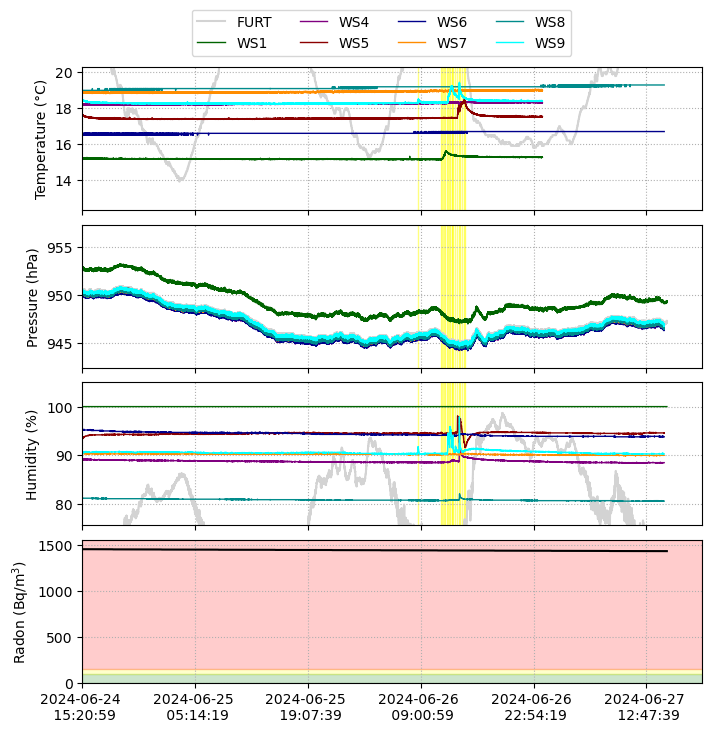

In [32]:
fig = __makeplot();

In [33]:
fig.savefig(config['path_to_figs']+f"html2_wromy.png", format="png", dpi=150, bbox_inches='tight')

In [34]:
del fig